# HMSC with the FIM Data

Let's take a look at what the difference is between the normal NNGP procedure I used previously and the GPP procedure that works blazing fast on a GPU.

First we need to load `rpy2` to be able to run R from Python.

Next we'll load the R libraries we need and set up the file system to handle the gpu models.

In [3]:
library(Hmsc)
library(tidyverse)
library(sp)
library(jsonify)

setwd('FIM/Bay')
(fileDir <- getwd())


[1] "c:/Users/Jonathan.Peake/Documents/GitHub Repositories/hmsc-hpc-image/FIM/Bay"

In [4]:
fileDir <- getwd()
dir.create(file.path(fileDir, "Model", "init"), recursive = T)
dir.create(file.path(fileDir, "Model", "fmR"))
dir.create(file.path(fileDir, "Model", "fmTF"))

Optionally make the directories if you haven't already.

Now let's load in the data.

In [5]:
load('Data/HMSCdat_bay.RData')

Next we set up the hmsc sampling parameters.

In [ ]:
bay <- c('AP', 'CK', 'TB', 'CH', 'JX', 'IR', 'TQ')
nChains = 1
test.run = T
if (test.run) {
  # With this option, the analysis runs fast but results are not reliable
  thin = 1
  samples = 5
  transient = 10
  verbose = 1
  npar = 1
} else {
  # With this option, the analysis evaluates slowly (and may not run at all based on memory limitations), but produces the full analysis
  thin = 100
  samples = 500
  transient = thin * samples
  verbose = 1
  npar = 4
}

Finally, let's set up our model and initialize for running on the GPU.

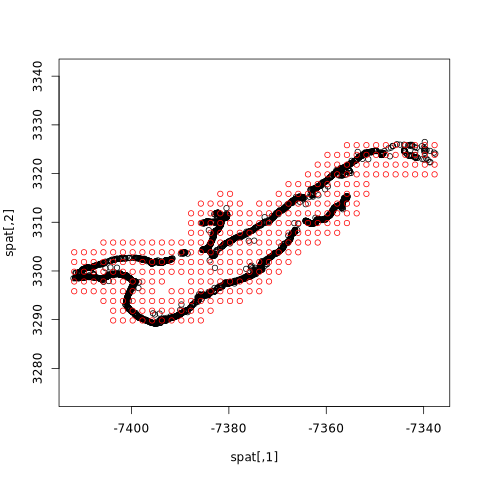

In [ ]:
hmsc_mods <- hmsc_dat %>%
  filter(Bay %in% bay) %>%
  mutate(
    ref = map(Reference, ~ .$Reference),

    # Assign an index for each geographical location; some lat longs are duplicated across the dataset, so we need to assign a unique identifier for each location
    geo_ind = map(spat, ~ group_indices(group_by(., Latitude, Longitude))),

    # Initialize the HMSC model for each bay
    hmsc_mod = pmap(
      list(geo_ind, ref, predictors, spat, Year, Month, bio),
      function(i, u, v, w, x, y, z) {
        # Filter the biotic data for hyper-rare species (occurring in less than 0.5% of samples)
        z <- z %>%
          select(where(~ sum(.x != 0) / length(.x) > 0.005))

        # Assign date as decimal year
        date_YM <- as.matrix(x + y / 12)

        # Convert spatial data to matrix
        spat <- as.matrix(cbind((w$Longitude), (w$Latitude)))
        kn <- constructKnots(spat, knotDist = 2, minKnotDist = 4)
        plot(spat, asp = 1)
        points(kn, col = "red")

        # Assign unique row names to spatial and temporal data (required for HMSC)
        rownames(spat) <- i
        rownames(date_YM) <- date_YM

        # Set study design dataframe with location, year, decimal date, and sample ID
        studyDesign <- data.frame(
          Loc = as.factor(i),
          Year = as.factor(as.matrix(x)),
          Time = as.factor(date_YM),
          Sample = as.factor(u)
        )

        # Assign row names of study design matrix
        rownames(studyDesign) <- u

        # Initalize random levels for the HMSC model
        rl1 <- HmscRandomLevel(units = studyDesign$Year) # Year
        rl2 <- HmscRandomLevel(sData = unique(date_YM)) # Time
        rl2 <- setPriors(rl2, nfMin = 1, nfMax = 8) # Set priors for the time random level
        rl3 <- HmscRandomLevel(
          sData = unique(spat),
          sMethod = "GPP",
          sKnot = kn
        ) # Location

        alphaN = 50
        enclosingRectDiag <- sqrt(sum(
          apply(spat, 2, function(c) diff(range(c)))^2
        ))
        alphapw <- cbind(
          c(0, seq(2, enclosingRectDiag, length = alphaN)),
          c(0.5, rep(0.5 / alphaN, alphaN))
        )

        rl3 <- setPriors(rl3, nfMin = 1, nfMax = 8, alphapw = alphapw) # Set priors for the location random level
        rl4 <- HmscRandomLevel(units = studyDesign$Sample) # Sample

        # Set spike-slab covariate selection parameters
        qq <- 0.1 # Prior probability required for inclusion set at 0.1
        nc <- ncol(v)
        ns <- ncol(z)

        XSelect <- list()
        for (k in 1:nc) {
          covGroup <- k
          spGroup <- 1:ns
          q <- rep(qq, max(spGroup))
          XSelect[[k]] <- list(covGroup = covGroup, spGroup = spGroup, q = q)
        }

        # Initialize the HMSC model with a lognormal poisson
        m <- Hmsc(
          Y = z,
          XData = v,
          XFormula = ~.,
          XSelect = XSelect,
          studyDesign = studyDesign,
          ranLevels = list(Year = rl1, Time = rl2, Loc = rl3, Sample = rl4),
          distr = "lognormal poisson"
        )
        saveRDS(m, file = 'Model/modAP.rds')

        m <- sampleMcmc(
          m,
          samples = samples,
          thin = thin,
          transient = transient,
          nChains = nChains,
          verbose = verbose,
          engine = "HPC",
          updater = list(Gamma2 = FALSE, GammaEta = FALSE)
        )

        init_file <- file.path(
          fileDir,
          "Model",
          "init",
          paste0("init_", bay, ".rds")
        )
        fitTF_file <- file.path(
          fileDir,
          "Model",
          "fmTF",
          paste0("fitTF_", bay, ".rds")
        )
        saveRDS(to_json(m), file = init_file)

        return(list(mod = m, init_file = init_file, fitTF_file = fitTF_file))
      }
    )
  )

In [ ]:
%%R
setwd('~')

Before we run on the GPU, we need to make sure the kernel knows where our hmsc python library is by reinstalling and restarting the kernel.

In [ ]:
%uv pip install hmsc
# Restart

Using Python 3.11.14 environment at: /srv/conda/envs/notebook
Audited 1 package in 50ms
Note: you may need to restart the kernel to use updated packages.


Now let's run the model on the GPU.

In [ ]:
!python - m
hmsc.run_gibbs_sampler - -input
'FIM/Bay/Model/init/init_AP.rds' - -output
'FIM/Bay/Model/fmTF/TF_AP.rds' - -samples
100 - -transient
50000 - -thin
100 - -verbose
100

2026-02-20 17:07:11.278104: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-20 17:07:11.689054: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-20 17:07:17.110470: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
args=Namespace(samples=100, transient=50000, thin=100, chains=None, input='FIM/B

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(Hmsc)
library(tidyverse)
library(sp)
library(jsonify)

setwd('~/FIM/Bay')
fileDir <- getwd()

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: coda


In [ ]:
%%R
HPC <- base::readRDS(file = 'Model/fmTF/TF_AP.rds')[[1]]
importFromHPC <- from_json(HPC)
postList = importFromHPC[1]
cat(sprintf("fitting time %.1f sec\n", importFromHPC[[2]]))

fitting time 7312.0 sec


In [ ]:
%%R
m <- base::readRDS(file = 'Model/modAP.rds')
fitTF = importPosteriorFromHPC(m, postList, 100, 100, 50000)
getPostEstimate(fitTF,'Alpha', r = 3)

$mean
[1] 0 0 0 0 0 0 0 0

$support
[1] 0 0 0 0 0 0 0 0

$supportNeg
[1] 0 0 0 0 0 0 0 0

